In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    "rock_paper_scissors",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

print(ds_info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.9H0GGA_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.9H0GGA_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author 

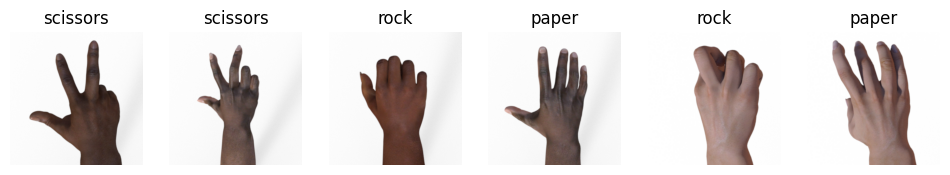

In [3]:
def show_samples(ds, n=6):
    plt.figure(figsize=(12,4))
    for i, (img, label) in enumerate(ds.take(n)):
        plt.subplot(1, n, i+1)
        plt.imshow(img.numpy())
        plt.title(ds_info.features["label"].names[label])
        plt.axis("off")
    plt.show()

show_samples(ds_train)


In [4]:
IMG_SIZE = (128, 128)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH).prefetch(AUTOTUNE)
test_ds  = ds_test.map(preprocess).batch(BATCH).prefetch(AUTOTUNE)


In [5]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


In [6]:
NUM_CLASSES = ds_info.features["label"].num_classes

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_aug,

    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15
)


Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.4436 - loss: 1.0387 - val_accuracy: 0.8172 - val_loss: 0.3694
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9027 - loss: 0.2965 - val_accuracy: 0.9220 - val_loss: 0.1752
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9622 - loss: 0.1235 - val_accuracy: 0.9543 - val_loss: 0.1724
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9740 - loss: 0.0756 - val_accuracy: 0.8710 - val_loss: 0.5001
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9798 - loss: 0.0703 - val_accuracy: 0.9113 - val_loss: 0.3059
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9857 - loss: 0.0547 - val_accuracy: 0.9516 - val_loss: 0.2078
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9884 - loss: 0.0343 - val_accuracy: 0.9516 - val_loss: 0.1160
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9945 - loss: 0.0220 - val_accuracy: 0.9167 - 

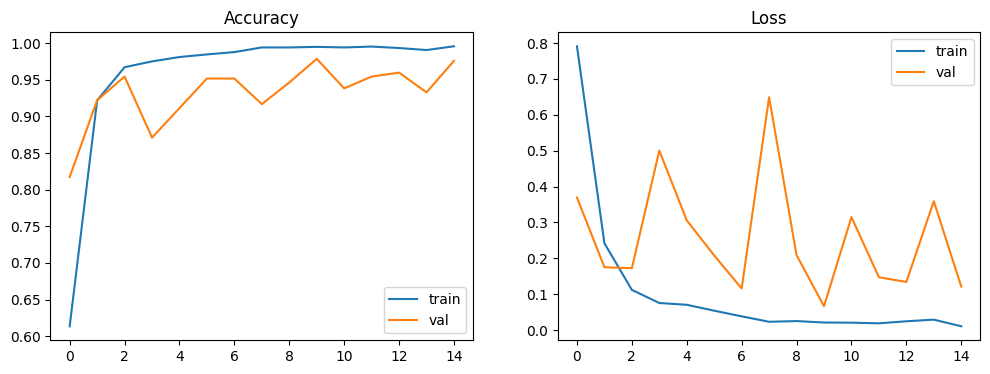

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val")
plt.title("Loss")
plt.legend()

plt.show()


In [9]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9810 - loss: 0.1085
Test Accuracy: 0.975806474685669


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


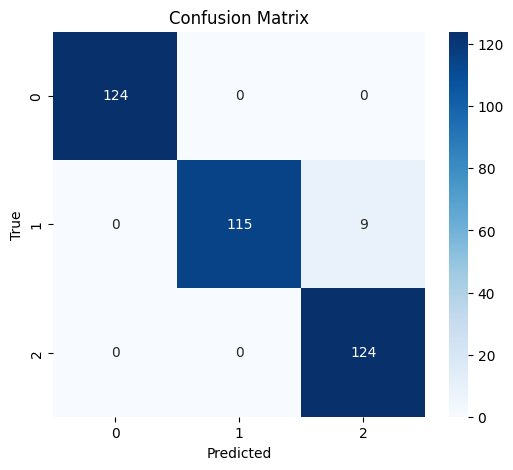

              precision    recall  f1-score   support

        rock       1.00      1.00      1.00       124
       paper       1.00      0.93      0.96       124
    scissors       0.93      1.00      0.96       124

    accuracy                           0.98       372
   macro avg       0.98      0.98      0.98       372
weighted avg       0.98      0.98      0.98       372



In [10]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=ds_info.features["label"].names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


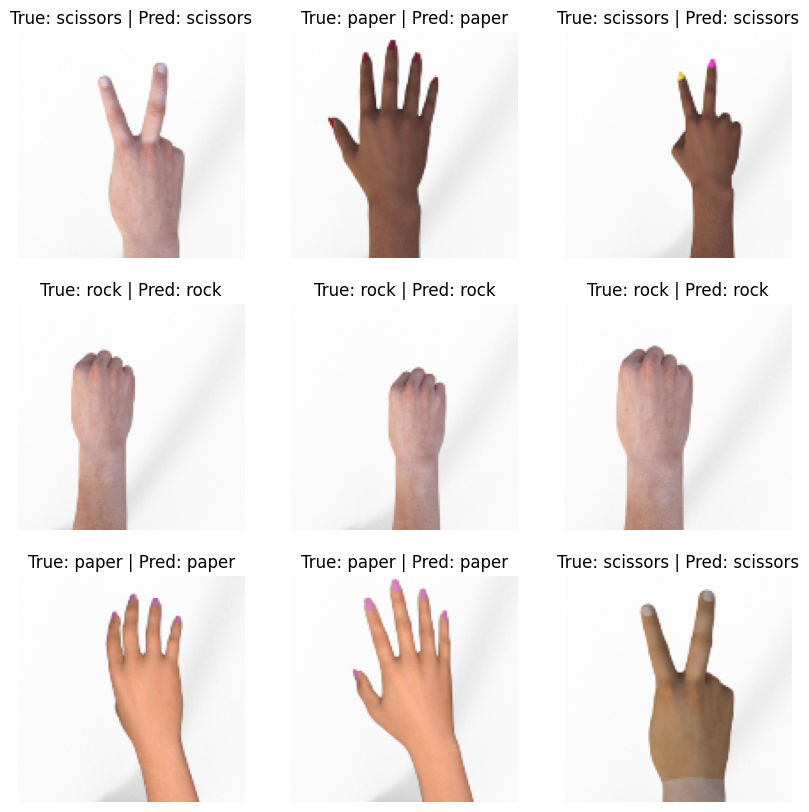

In [11]:
def show_predictions(model, dataset, n=9):
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)

        plt.figure(figsize=(10,10))
        for i in range(n):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy())
            t = ds_info.features["label"].names[labels[i].numpy()]
            p = ds_info.features["label"].names[preds[i]]
            plt.title(f"True: {t} | Pred: {p}")
            plt.axis("off")
        break

show_predictions(model, test_ds)


In [12]:
model.save("rock_paper_scissors_cnn.h5")
print("Model saved as rock_paper_scissors_cnn.h5")


Model saved as rock_paper_scissors_cnn.h5
